In [2]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
import glob
from itertools import combinations

pd.set_option('display.max_columns', None)

""" Loading/conversion of Enugu Election csv file to pandas DataFrame"""
df = pd.read_csv('C:\\Users\\DELL\\Videos\\ASIAN SERIES\\DOCTOR SLUMP\\Enugu_file.csv')

""" Replacing multiple substrings (-, _) from Dataframe column name """
df.columns = df.columns.str.replace(r'[_-]', ' ', regex=True)

""" Creating and applying a function to Convert the text values in each Column to Sentence case """
def capitalize_values(text):
    if text:
        return text.lower().capitalize()
    else:
        text
for col in df.select_dtypes(include=[object]).columns:
    df[col] = df[col].apply(lambda x: capitalize_values(x))

""" Creating a new column called Addresses based of PU Name, Ward and State Columns """
df['Addresses'] = df['PU Name'].str.cat(df['Ward'], sep=', ').str.cat(df['State'], sep=', ')

""" Exporting the DataFrame with the Address column to a excel file format named Enugu_geocode2.xlsx """
with pd.ExcelWriter('C:\\Users\\DELL\\Videos\\ASIAN SERIES\\DOCTOR SLUMP\\Enugu_geocode2.xlsx') as writer:
    df.to_excel(writer, sheet_name='Sheet1', index=False)
    
""" Importing multiple Excel file containing Geocoded Addresses using glob library and creating a new Dataframe """ 
file_path = 'C:\\Users\\DELL\\OneDrive\\Documents\\GEOCODED FILE\\*.xlsx'
excel_files = glob.glob(file_path)
dataframes = []
for file in excel_files:
    df1 = pd.read_excel(file)
    dataframes.append(df1)
    
geocoded_df = pd.concat(dataframes, ignore_index=True)

In [3]:
df5 = geocoded_df['Address'].duplicated().sum()

In [4]:
""" Delecting observed duplicate Address rows in the Geocoded Dataframe """
geocoded_df = geocoded_df.drop_duplicates('Address').reset_index(drop=True)

""" Delecting observed duplicate Addresses rows in the Original DataFrame"""
df = df.drop_duplicates('Addresses').reset_index(drop=True)

""" Creating Latitude and Longitude columns in the Original Dataframe based on that of the Geocoded Dataframe """
df['Latitude'] = geocoded_df['Latitude']
df['Longitude'] = geocoded_df['Longitude']

In [5]:
"""Create a distance matrix Ffunction to calculate the distance between all polling units based on their latitude and longitude"""
def calculate_distance_matrix(df, batch_size=100):
    num_units = df.shape[0]
    distance_matrix = np.zeros((num_units, num_units))
    
    for i in range(0, num_units, batch_size):
        batch_coords = df.loc[i:i+batch_size-1, ['Latitude', 'Longitude']].values
        combos = combinations(batch_coords, 2)
        distances = [geodesic(*combo).kilometers for combo in combos]
        offset = i * (i + 1) // 2
        distance_matrix.flat[offset:offset + len(distances)] = distances

    return distance_matrix

distance_matrix = calculate_distance_matrix(df)

In [6]:
threshold = 1  # Representing Distance/Radius in KM

""" Creating a Function to find the Neigbouring polling units for each polling unit"""
def find_neighbors(distance_matrix, threshold):
    neighbors = {}
    for i in range(distance_matrix.shape[0]):
        neighbor_indices = np.where(distance_matrix[i] <= threshold)[0]
        neighbors[i] = neighbor_indices[neighbor_indices != i].tolist()
    return neighbors

neighbors = find_neighbors(distance_matrix, threshold)

In [7]:
party_votes = ['APC', 'LP', 'PDP', 'NNPP']  # creating a list of the political parties

def calculate_vote_differences(df, neighbors, party_votes):
    vote_differences = {party: np.zeros(df.shape[0]) for party in party_votes}
    for i, neighbor_list in enumerate(neighbors.values()):
        if neighbor_list:                                    # Check if neighbor_list is not empty
            for party in party_votes:
                vote_differences[party][i] = np.abs(df.loc[i, party] - df.loc[neighbor_list, party].mean())
    return vote_differences

# Calculate vote differences
vote_differences = calculate_vote_differences(df, neighbors, party_votes)

for party, differences in vote_differences.items():
    df[f'{party} Outlier Score'] = differences


In [8]:
""" Creating Neighbouring unit column """
df['Neighboring Units'] = df.index.map(lambda x: ', '.join(df.loc[neighbors[x], 'PU Name']))

""" Calculating the standard deviation of vote difference (outlier score) for each political party"""
std_devs = {party: np.std(differences) for party, differences in vote_differences.items()}

""" Defining the threshold for outlier classification for each political party"""
thresholds = {party: std_dev * 1.5 for party, std_dev in std_devs.items()}
print(thresholds)

""" Filter the DataFrame based on the threshold values 1 (outlier) and 0(Non outlier) and creating parties outliers columns"""
df['APC Outlier'] = np.where(df['APC Outlier Score'] > thresholds['APC'], 1, 0) 
df['LP Outlier'] = np.where(df['LP Outlier Score'] > thresholds['LP'], 1, 0)
df['PDP Outlier'] = np.where(df['PDP Outlier Score'] > thresholds['PDP'], 1, 0)
df['NNPP Outlier'] = np.where(df['NNPP Outlier Score'] > thresholds['NNPP'], 1, 0)

df.to_csv('C:\\Users\\DELL\\OneDrive\\Documents\\TASK 1\\Task_1_complete_table.csv', index=False, header=True, sep=';', na_rep='NULL')

{'APC': 13.250754489276527, 'LP': 79.57293743308017, 'PDP': 10.853343856726802, 'NNPP': 7.3452648715029945}


In [9]:
outliers_df = df[(df['APC Outlier'] == 1) | (df['LP Outlier'] == 1) | (df['PDP Outlier'] == 1) 
                  | (df['NNPP Outlier'] == 1)][['PU Name', 'Neighboring Units', 'Latitude', 'Longitude',
                  'APC Outlier Score', 'LP Outlier Score', 'PDP Outlier Score', 'NNPP Outlier Score', 'APC Outlier',
                  'LP Outlier', 'PDP Outlier', 'NNPP Outlier']].reset_index(drop=True)

In [10]:
outliers_df['PU Name'] = outliers_df['PU Name'].str.upper()

In [11]:
APC_outliers_df = outliers_df[outliers_df['APC Outlier'] == 1][['PU Name', 'Neighboring Units', 'Latitude', 
                  'Longitude', 'APC Outlier Score', 'APC Outlier']].sort_values('APC Outlier Score', 
                   ascending=False).reset_index(drop=True)

In [12]:
APC_outliers_df.head(3)

,PU Name,Neighboring Units,Latitude,Longitude,APC Outlier Score,APC Outlier
0,C.P.S. OHODO,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.751958,7.411099,498.823350,1
1,UWANI OTOBO VILLAGE SQUARE,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.408823,7.500360,123.719357,1
2,OJIAGU TOWN HALL,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.304964,7.562641,67.703827,1


In [13]:
LP_outliers_df = outliers_df[outliers_df['LP Outlier'] == 1][['PU Name', 'Neighboring Units', 'Latitude', 
                  'Longitude', 'LP Outlier Score', 'LP Outlier']].sort_values('LP Outlier Score', 
                   ascending=False).reset_index(drop=True)
LP_outliers_df.head(3)

,PU Name,Neighboring Units,Latitude,Longitude,LP Outlier Score,LP Outlier
0,COMMUNITY PRIMARY SCHOOL OWERRE OBUKPA,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.883657,7.425528,490.875208,1
1,FEDERAL GOVERNMENT SCHOOL I,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.424580,7.523963,465.868275,1
2,AGBUGWU OWERRE ANI,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.851975,7.397945,444.862451,1


In [14]:
PDP_outliers_df = outliers_df[outliers_df['PDP Outlier'] == 1][['PU Name', 'Neighboring Units', 'Latitude', 
                  'Longitude', 'PDP Outlier Score', 'PDP Outlier']].sort_values('PDP Outlier Score', 
                   ascending=False).reset_index(drop=True)
PDP_outliers_df.head(3)

,PU Name,Neighboring Units,Latitude,Longitude,PDP Outlier Score,PDP Outlier
0,MBAGUZO VILLAGE SQUARE,"Obuagu village square ezinato i, Obuagu villag...",6.507597,7.693188,122.922640,1
1,RAILWAY STATION,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.215122,7.578898,120.213810,1
2,CENTRAL SCHOOL OWO I,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.507597,7.693188,110.211037,1


In [15]:
NNPP_outliers_df = outliers_df[outliers_df['NNPP Outlier'] == 1][['PU Name', 'Neighboring Units', 'Latitude', 
                  'Longitude', 'NNPP Outlier Score', 'NNPP Outlier']].sort_values('NNPP Outlier Score', 
                   ascending=False).reset_index(drop=True)
NNPP_outliers_df.head(3)

,PU Name,Neighboring Units,Latitude,Longitude,NNPP Outlier Score,NNPP Outlier
0,COMMUNITY PRIMARY SCHOOL ENUGU UMUABI,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.279631,7.380104,268.531614,1
1,C.P.S. AKPOGA I,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.510131,7.622266,103.485857,1
2,AMAKPAKA HALL III,"Comm. sch. oduma achara, Mmafu comm. school, O...",6.622265,7.562641,42.468941,1


In [16]:
with pd.ExcelWriter('C:\\Users\\DELL\\OneDrive\\Documents\\TASK 1\\Party_outliers.xlsx') as writer:
    APC_outliers_df.to_excel(writer, sheet_name='APC', index=False, header=True)
    LP_outliers_df.to_excel(writer, sheet_name='LP', index=False, header=True)
    PDP_outliers_df.to_excel(writer, sheet_name='PDP', index=False, header=True)
    NNPP_outliers_df.to_excel(writer, sheet_name='NNPP', index=False, header=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_5276\1812852779.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(top_NNPP_outliers['PU Name'], fontsize=20, fontname='Times New Roman')
C:\Users\DELL\AppData\Local\Temp\ipykernel_5276\1812852779.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(top_APC_outliers['PU Name'], fontsize=20, fontname='Times New Roman')


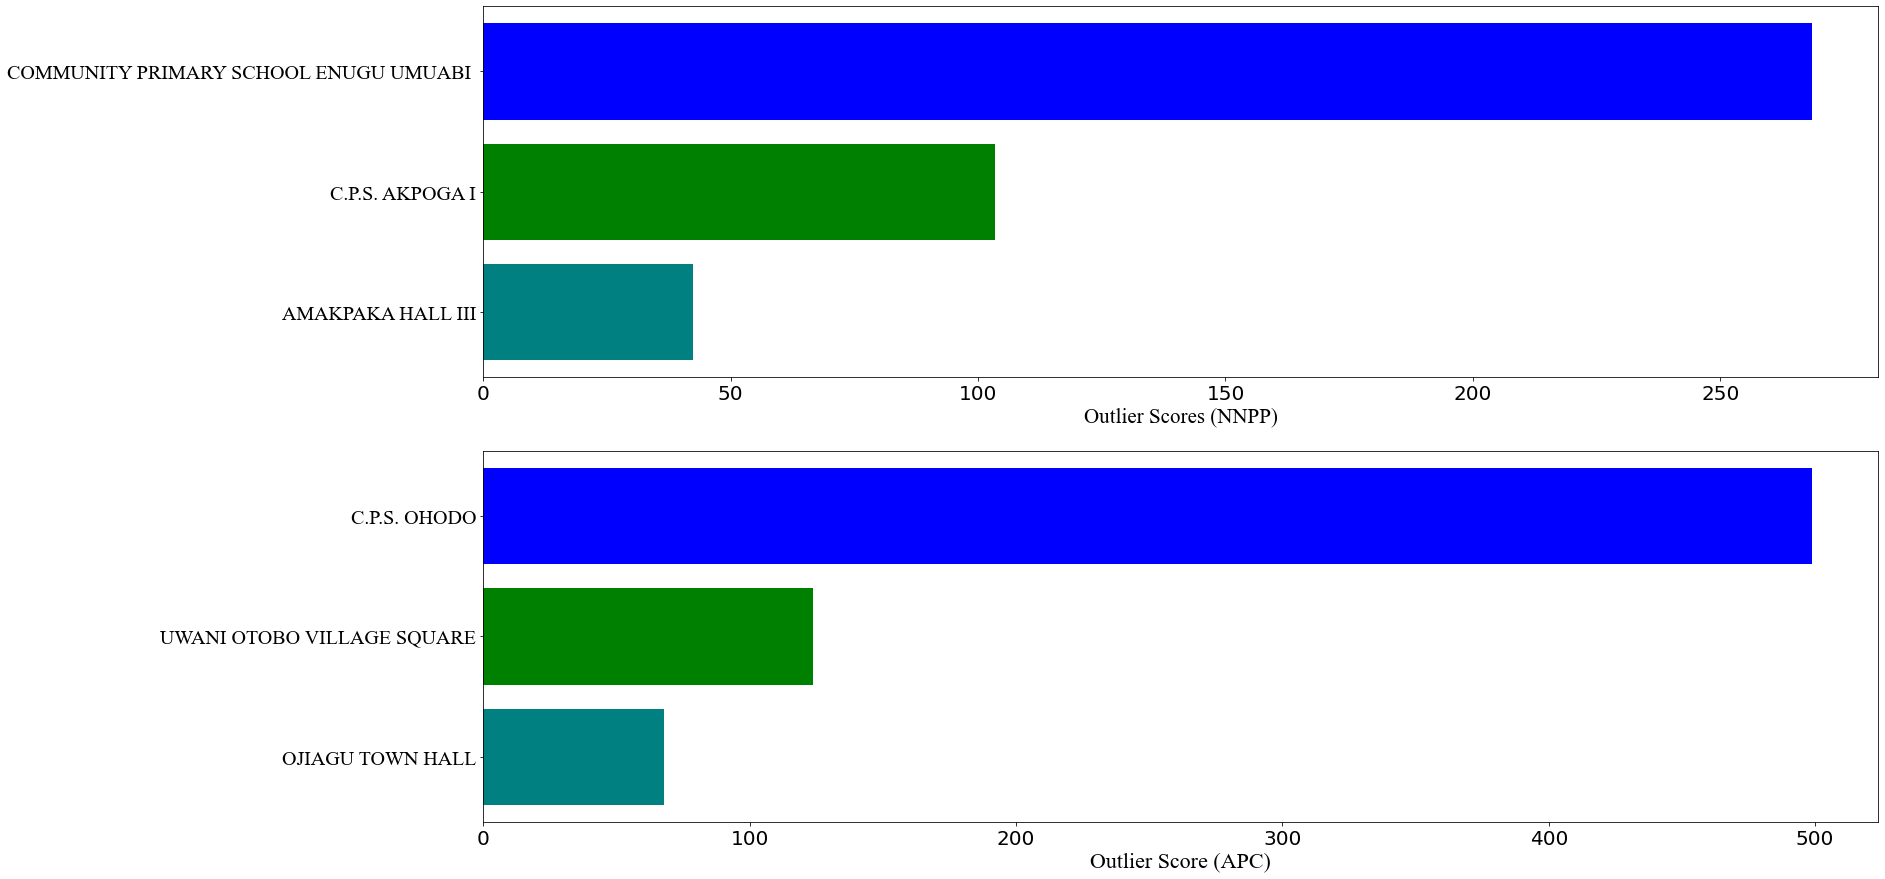

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax = ax.flatten()

colour = ['Teal', 'Green', 'Blue']

top_NNPP_outliers = NNPP_outliers_df.nlargest(3, 'NNPP Outlier Score')
top_NNPP_outliers = top_NNPP_outliers.sort_values('NNPP Outlier Score', ascending=True)

ax[0].barh(top_NNPP_outliers['PU Name'], top_NNPP_outliers['NNPP Outlier Score'], color=colour)
ax[0].set_yticklabels(top_NNPP_outliers['PU Name'], fontsize=20, fontname='Times New Roman')
ax[0].set_xlabel('Outlier Scores (NNPP)', fontsize=21, fontname='Times New Roman')
ax[0].tick_params(axis='x', which='major', labelsize=20)


top_APC_outliers = APC_outliers_df.nlargest(3, 'APC Outlier Score')
top_APC_outliers = top_APC_outliers.sort_values('APC Outlier Score', ascending=True)

ax[1].barh(top_APC_outliers['PU Name'], top_APC_outliers['APC Outlier Score'], color=colour)
ax[1].set_yticklabels(top_APC_outliers['PU Name'], fontsize=20, fontname='Times New Roman')
ax[1].set_xlabel('Outlier Score (APC)', fontsize=22, fontname='Times New Roman')
ax[1].tick_params(axis='x', which='major', labelsize=20)

plt.savefig('C:\\Users\\DELL\\OneDrive\\Documents\\TASK 1\\Top_outliers_NNPP_APC.png')


plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_5276\2754200506.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(top_LP_outliers['PU Name'], fontsize=18, fontname='Times New Roman')
C:\Users\DELL\AppData\Local\Temp\ipykernel_5276\2754200506.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(top_PDP_outliers['PU Name'], fontsize=18, fontname='Times New Roman')


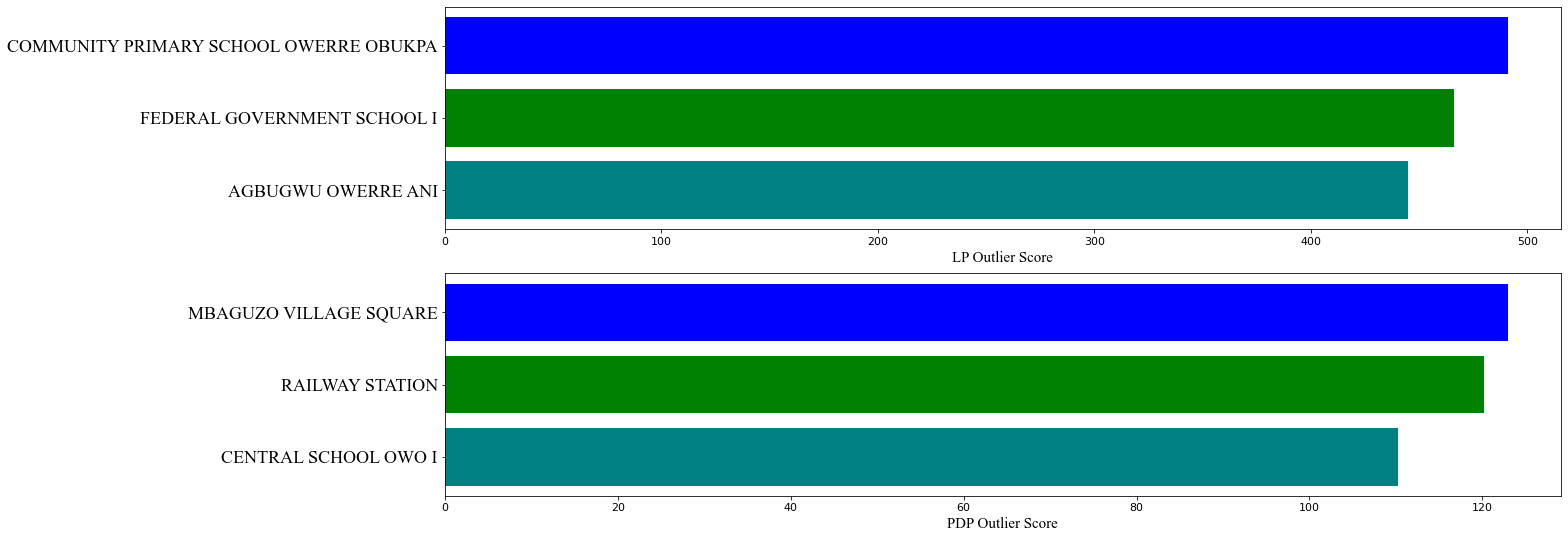

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20, 9))
ax = ax.flatten()

colour = ['Teal', 'Green', 'Blue']

top_LP_outliers = LP_outliers_df.nlargest(3, 'LP Outlier Score')
top_LP_outliers = top_LP_outliers.sort_values('LP Outlier Score', ascending=True)

ax[0].barh(top_LP_outliers['PU Name'], top_LP_outliers['LP Outlier Score'], color=colour)
ax[0].set_yticklabels(top_LP_outliers['PU Name'], fontsize=18, fontname='Times New Roman')
ax[0].set_xlabel('LP Outlier Score', fontsize=15, fontname='Times New Roman')
ax[0].tick_params(axis='x', which='major', labelsize=11)

top_PDP_outliers = PDP_outliers_df.nlargest(3, 'PDP Outlier Score')
top_PDP_outliers = top_PDP_outliers.sort_values('PDP Outlier Score', ascending=True)

ax[1].barh(top_PDP_outliers['PU Name'], top_PDP_outliers['PDP Outlier Score'], color=colour)
ax[1].set_yticklabels(top_PDP_outliers['PU Name'], fontsize=18, fontname='Times New Roman')
ax[1].set_xlabel('PDP Outlier Score', fontsize=15, fontname='Times New Roman')
ax[1].tick_params(axis='x', which='major', labelsize=11)

plt.savefig('C:\\Users\\DELL\\OneDrive\\Documents\\TASK 1\\Top_outlier_PDP_LP.png')


plt.show()

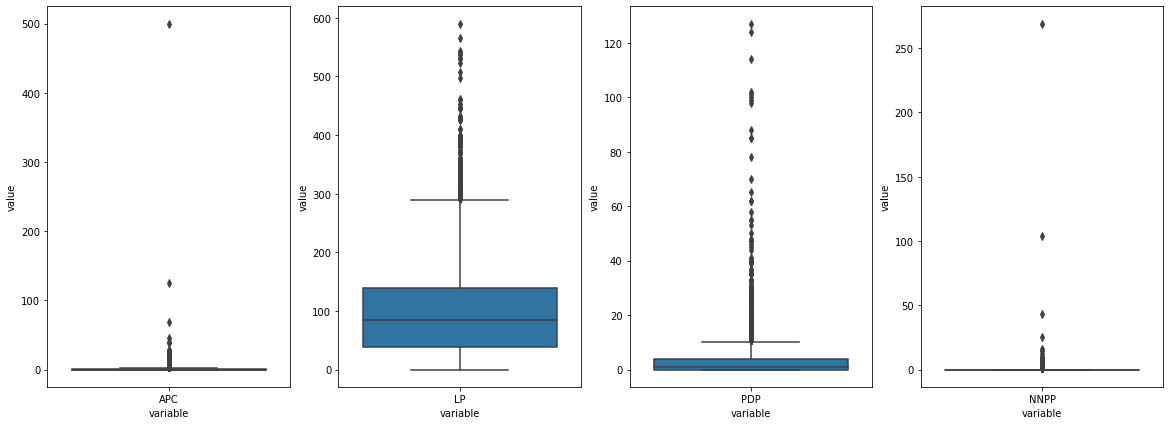

In [68]:
# Box plot showing distribution

fig, ax = plt.subplots(1, 4, figsize=(20, 7))
ax = ax.flatten()

df1 = df[['APC', 'LP', 'PDP', 'NNPP']]

df_boxplot = pd.melt(df1) # Convert df1 Columns to Row(variable) and Row to Columns(value)

sns.boxplot(x='variable', y='value', data=df_boxplot[df_boxplot['variable'] == 'APC'], ax=ax[0])  
sns.boxplot(x='variable', y='value', data=df_boxplot[df_boxplot['variable'] == 'LP'], ax=ax[1])  
sns.boxplot(x='variable', y='value', data=df_boxplot[df_boxplot['variable'] == 'PDP'], ax=ax[2])  
sns.boxplot(x='variable', y='value', data=df_boxplot[df_boxplot['variable'] == 'NNPP'], ax=ax[3])

plt.savefig('C:\\Users\\DELL\\OneDrive\\Documents\\TASK 1\\distribution_plot.png')

plt.show()